In [80]:
%matplotlib inline
import matplotlib.pyplot as plt

In [81]:
import pydicom
!pip show pydicom

You are using pip version 8.1.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [82]:
from path import Path

In [83]:
ct_dir_path = Path('/mnt/data/olivierv/Cyl/AC_CT_0003/')

In [84]:
!ls -d {ct_dir_path}

/mnt/data/olivierv/Cyl/AC_CT_0003/


In [85]:
import numpy as np

In [86]:
%%time
#volume = np.array([pydicom.dcmread(f).pixel_array for f in ct_dir_path.listdir()])

imas = [pydicom.dcmread(f) for f in ct_dir_path.listdir()]

shuffled_volume = np.array([ima.pixel_array for ima in imas])

pos = [int(ima.InstanceNumber) - 1 for ima in imas]

volumect = np.zeros_like(shuffled_volume)

volumect[pos] = shuffled_volume

CPU times: user 308 ms, sys: 116 ms, total: 424 ms
Wall time: 440 ms


In [87]:
#ima = pydicom.dcmread(ct_dir_path.listdir()[0])

### Rescaling/Shifting

In [88]:
ima.RescaleIntercept, ima.RescaleSlope

("-1024", "1")

In [89]:
volume_ = ima.RescaleSlope*volumect.astype(np.float) + ima.RescaleIntercept

# Converstion to Attenuation

We use the following formula (from Carney Med Phys 33(4) 2006 (https://aapm.onlinelibrary.wiley.com/doi/full/10.1118/1.2174132)):

If $x < $ breakpoint, then $f(x) = (x + 1000)9.6 \times 10^{-5}$

If $x > $ breakpoint, then $f(x) = a(x + 1000) + b$

Note: the conversion values above depend on the kvp, and are obtained from table III from Carney above:

In [90]:
#def attenuation_conversion(volume, breakpoint=50, a=5.1e-5, b=4.71e-2):
kvp = ima.KVP
if kvp == 80 : 
        a = 3.64e-5
        b=6.261e-2
        breakpoint=50
if kvp == 100 : 
        a = 4.43e-5
        b=5.44e-2
        breakpoint=52
if kvp == 110 : 
        a = 4.92e-5
        b=4.88e-2
        breakpoint=43
if kvp == 120 : 
        a = 5.1e-5
        b=4.71e-2
        breakpoint=47
if kvp == 130 : 
        a = 5.51e-5
        b=4.24e-2
        breakpoint=37
if kvp == 140 : 
        a = 5.64e-5
        b=4.08e-2
        breakpoint=30
def attenuation_conversion(volume, breakpoint, a, b):
    attenuation = np.zeros_like(volume)
    small = volume < breakpoint
    attenuation[small] = (volume[small] + 1000)*(9.6e-5)
    attenuation[~small] = a*(volume[~small] + 1000) + b
    return attenuation

In [69]:
attenuation = attenuation_conversion(volume_, breakpoint, a, b)

Unfortunately, some parts are still negative (because of the difference between 1024 and 1000, basically)

In [70]:
attenuation[attenuation < 0] = 0

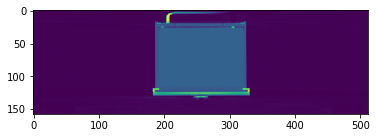

In [72]:
plt.imshow(volumect[:,256,:])

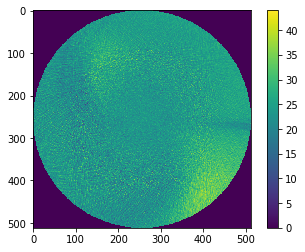

In [73]:
plt.imshow(volume[0,:,:])
plt.colorbar()

In [74]:
attenuation.shape

(158, 512, 512)

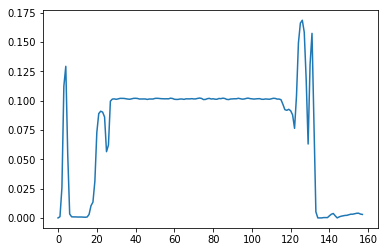

In [75]:
plt.plot(attenuation[:,256,256])

The following now works only for this particular case in which, by hand, I have registered the PET and CT images and come up with the fact that the CT image should be moved forward by 15 slices in the z direction (which is the first index). The solution of using the function roll is good as long as there are no attenuation structures in the last 15 slices (this is not exaclty true here).

In [77]:
from skimage.transform import resize

In [94]:
n_slice_from_reg = 15
reg_attenuation = np.roll(attenuation, n_slice_from_reg, axis=0)
reg_attenuation_b0 = reg_attenuation[0:132,:,:]
new_size_i = 200
new_size_j = 200
down_size = (133,200,200)
final_size = (109,101,101)
reg_attenuation_down = np.zeros(down_size)
for z in range(133):
    slice_or = reg_attenuation_b0[z-1,:,:]
#slice_down = np.zeros[new_size_i,new_size_j]
    slice_down = resize(slice_or,(new_size_i, new_size_j), anti_aliasing=True)
    reg_attenuation_down[z] = slice_down
reg_attenuation_final = np.zeros(final_size)
for i in range(101):
    slice_z = reg_attenuation_down[:,:,i-1]
    slice_z_down = resize(slice_z,(109,101), anti_aliasing=True)
    reg_attenuation_final[:,:,i] = slice_z_down

In [91]:
from skimage.transform import resize
n_slice_from_reg = 15
reg_attenuation = np.roll(attenuation, n_slice_from_reg, axis=0)
new_size_i = 101
new_size_j = 101
down_size = (158,101,101)
final_size = (109,101,101)
reg_attenuation_down = np.zeros(down_size)
for z in range(158):
    slice_or = reg_attenuation[z-1,:,:]
#slice_down = np.zeros[new_size_i,new_size_j]
    slice_down = resize(slice_or,(new_size_i, new_size_j), anti_aliasing=True)
    reg_attenuation_down[z] = slice_down
reg_attenuation_final = np.zeros(final_size)
for i in range(101):
    slice_z = reg_attenuation_down[:,:,i-1]
    slice_z_down = resize(slice_z,(109,101), anti_aliasing=True)
    reg_attenuation_final[i] = slice_down